# Import modules

In [6]:
import h5py
import json
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout

# Optimize performance

In [7]:
mixed_precision.set_global_policy('mixed_float16')

# Open hdf5 dataset structure

In [8]:
# Open dataset
with h5py.File(r'C:\Users\edfli\Downloads\brain_tumor_dataset\brain_tumor_dataset_train.h5', 'r') as hdf5_file:
    images_training = hdf5_file['images'][:]
    labels_training = hdf5_file['labels'][:]
print(images_training.shape, images_training.shape)

(2296, 256, 256, 3) (2296, 256, 256, 3)


# Define clases

In [9]:
classes = {0 : 'glioma_tumor',
           1 : 'meningioma_tumor',
           2 : 'normal',
           3 : 'pituitary_tumor'}

# Show images examples

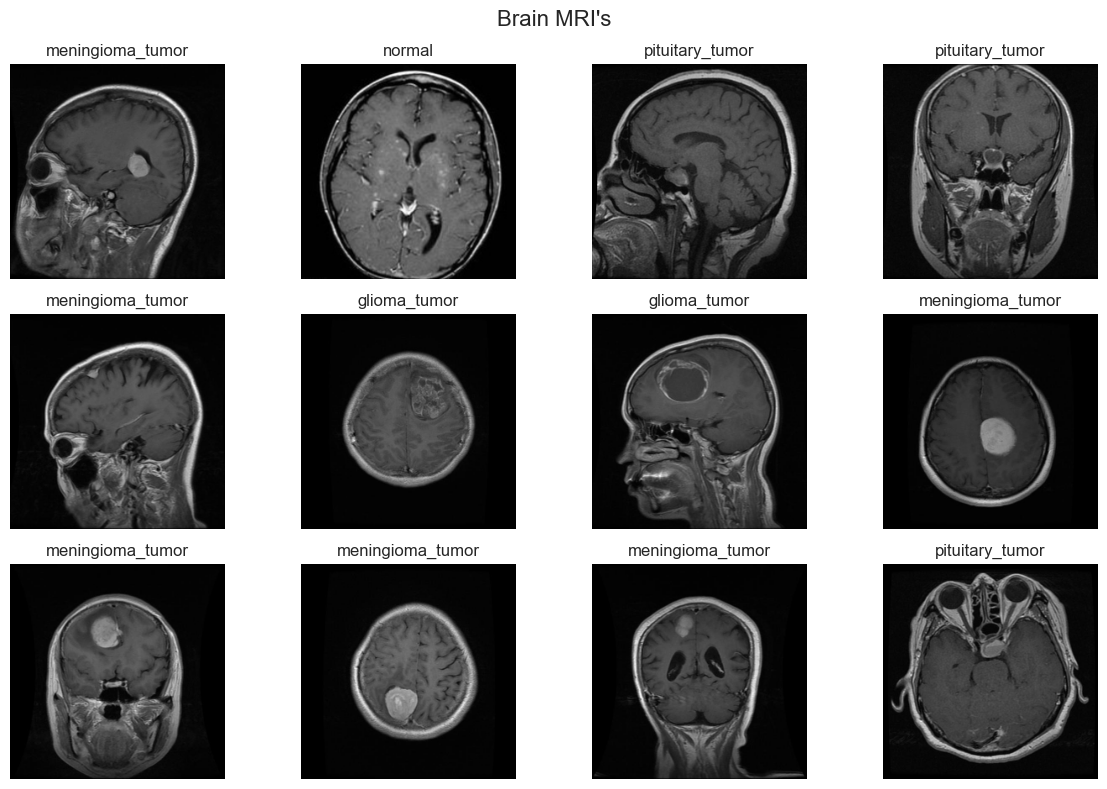

In [10]:
# Create a grid of pie charts
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

# Flatten the axis array for easy iteration
axs = axs.ravel()

for i in range(12):
    index_random = random.randint(0,images_training.shape[0])
    axs[i].imshow(images_training[index_random])
    axs[i].axis('off')
    axs[i].set_title(classes[labels_training[index_random]])
    #axs[i].grid()
fig.suptitle('Brain MRI\'s', fontsize=16)
plt.tight_layout()
#plt.grid()
plt.savefig('images/examples_Brain_MRIs.png', dpi=300, bbox_inches='tight')


plt.show()

# Functions to eval performance and save models

## Plot history loss and accuracy

In [11]:
def plot_history(historical):
  epochs = range(1, len(historical.history['loss'])+1)

  plt.figure(figsize = (12,4))


  plt.subplot(1,2,1)
  plt.plot(epochs, historical.history['loss'], label = 'Trainning loss')
  plt.plot(epochs, historical.history['val_loss'], label = 'validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Trainning and validation loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, historical.history['accuracy'], label = 'Trainning accuracy')
  plt.plot(epochs, historical.history['val_accuracy'], label = 'validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.title('Trainning and validation accuracy')
  plt.legend()
  plt.ylim(0, 1.1)

## Save model and history

In [12]:
def save_model_and_store_history(model, history, name):
    try:
        model.save('Saved_models_and_history/'+name + '.keras')#, save_format='tf')
        
        history_dict = {'accuracy': history.history['accuracy'],
                        'loss': history.history['loss'],
                        'val_accuracy' : history.history['val_accuracy'],
                        'val_loss' : history.history['val_loss']
                        }
        with open('Saved_models_and_history/'+name+'_history.json', 'w') as json_file:
            json.dump(history_dict, json_file)
    except:
        print('The folder to store the model and the history does not exists, please create it before run save_model_and_store_history')

# Define data Augmentation block

In [13]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(256,256,3)),  # Horizontal flip
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05),  # Random rotation up to 30 degrees
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),  # Random zoom up to 15%
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=.15, width_factor=.15),  # Random shear up to 20%
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255.0, input_shape=(256, 256, 3))
])

# Define models

## Define transfer learning models
* Import VGG16, ResNet50v2, InceptionResNetV2, MobileNetV2
* Turn off trainable parameter in each layer
* Add own fully connected layers

### VGG16

In [14]:
vgg_16 = keras.applications.VGG16(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in vgg_16.layers:
  layer.trainable = False

custom_vgg16 = Sequential()

#Preprocessing layers
custom_vgg16.add(data_augmentation)

custom_vgg16.add(vgg_16)
custom_vgg16.add(Flatten())
custom_vgg16.add(Dense(64, activation = 'relu'))
custom_vgg16.add(Dense(128, activation = 'relu'))
custom_vgg16.add(Dense(4, activation = 'softmax'))


custom_vgg16.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])

custom_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2097216   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 16,820,740
Trainable params: 2,106,052
Non-trainable params: 14,714,688
__________________________________

### ResNet50v2

In [15]:
ResNet50v2 = keras.applications.ResNet50V2(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in ResNet50v2.layers:
  layer.trainable = False

ResNet50v2_custom = Sequential()

#Preprocessing layers
ResNet50v2_custom.add(data_augmentation)

ResNet50v2_custom.add(ResNet50v2)
ResNet50v2_custom.add(Flatten())
ResNet50v2_custom.add(Dense(64, activation = 'relu'))
ResNet50v2_custom.add(Dense(128, activation = 'relu'))
ResNet50v2_custom.add(Dense(4, activation = 'softmax'))


ResNet50v2_custom.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])

ResNet50v2_custom.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8388672   
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 31,962,308
Trainable params: 8,397,508
Non-trainable params: 23,564,800
__________________________________

### InceptionResNetv2

In [16]:
InceptionResNetv2 = keras.applications.InceptionResNetV2(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in InceptionResNetv2.layers:
  layer.trainable = False

InceptionResNetv2_custom = Sequential()

#Preprocessing layers
InceptionResNetv2_custom.add(data_augmentation)

InceptionResNetv2_custom.add(InceptionResNetv2)
InceptionResNetv2_custom.add(Flatten())
InceptionResNetv2_custom.add(Dense(64, activation = 'relu'))
InceptionResNetv2_custom.add(Dense(128, activation = 'relu'))
InceptionResNetv2_custom.add(Dense(4, activation = 'softmax'))


InceptionResNetv2_custom.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])

InceptionResNetv2_custom.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 55296)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                3539008   
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 516       
Total params: 57,884,580
Trainable params: 3,547,844
Non-trainable params: 54,336,736
__________________________________

### MobileNetv2

In [17]:
MobileNetv2 = keras.applications.MobileNetV2(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in MobileNetv2.layers:
  layer.trainable = False

MobileNetv2_custom = Sequential()

#Preprocessing layers
MobileNetv2_custom.add(data_augmentation)

MobileNetv2_custom.add(MobileNetv2)
MobileNetv2_custom.add(Flatten())
MobileNetv2_custom.add(Dense(64, activation = 'relu'))
MobileNetv2_custom.add(Dense(128, activation = 'relu'))
MobileNetv2_custom.add(Dense(4, activation = 'softmax'))


MobileNetv2_custom.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])

MobileNetv2_custom.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
flatten_3 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                5242944   
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 7,509,764
Trainable params: 5,251,780
Non-trainable params: 2,257,984
____________________________________

## Define simple CNN model

In [18]:
simple_CNN = Sequential()

simple_CNN.add(Conv2D(128, (3, 3), input_shape=( 256, 256, 3), activation='relu'))
simple_CNN.add(MaxPooling2D(pool_size=(2, 2)))

simple_CNN.add(Conv2D(128, (3, 3), activation='relu'))
simple_CNN.add(MaxPooling2D(pool_size=(2, 2)))

simple_CNN.add(Conv2D(128, (3, 3), activation='relu'))
simple_CNN.add(MaxPooling2D(pool_size=(2, 2)))

simple_CNN.add(Flatten())

simple_CNN.add(Dense(128, activation='relu'))
simple_CNN.add(Dropout(0.33))

simple_CNN.add(Dense(256, activation = 'relu'))
simple_CNN.add(Dropout(0.5))

simple_CNN.add(Dense(4, activation = 'softmax'))


simple_CNN.compile(#loss='sparse_categorical_crossentropy',
                loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer= "adam",
              metrics=['accuracy'],
              )

simple_CNN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_203 (Conv2D)          (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 125, 125, 128)     147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 60, 60, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 115200)           

# Train models

## VGG16

### Train VGG16

Epoch 1/20
58/58 [==============================] - 10s 87ms/step - loss: 1.1449 - accuracy: 0.5060 - val_loss: 0.6706 - val_accuracy: 0.7109
Epoch 2/20
58/58 [==============================] - 5s 80ms/step - loss: 0.7185 - accuracy: 0.6983 - val_loss: 0.7133 - val_accuracy: 0.7304
Epoch 3/20
58/58 [==============================] - 5s 80ms/step - loss: 0.6016 - accuracy: 0.7527 - val_loss: 0.7239 - val_accuracy: 0.7283
Epoch 4/20
58/58 [==============================] - 5s 82ms/step - loss: 0.4972 - accuracy: 0.8023 - val_loss: 0.5384 - val_accuracy: 0.8152
Epoch 5/20
58/58 [==============================] - 5s 82ms/step - loss: 0.4715 - accuracy: 0.8143 - val_loss: 0.5141 - val_accuracy: 0.8217
Epoch 6/20
58/58 [==============================] - 5s 80ms/step - loss: 0.4472 - accuracy: 0.8246 - val_loss: 0.4338 - val_accuracy: 0.8500
Epoch 7/20
58/58 [==============================] - 5s 80ms/step - loss: 0.3801 - accuracy: 0.8464 - val_loss: 0.3502 - val_accuracy: 0.8848
Epoch 8/20
5

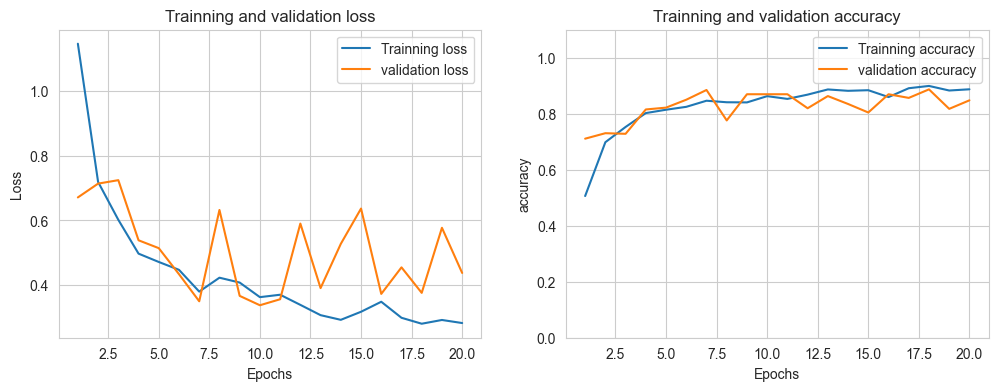

In [19]:
historical_custom_vgg16 = custom_vgg16.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    #validation_data = (images_validation, to_categorical(labels_validation)),
                                    validation_split=.2,
                                    )
plot_history(historical_custom_vgg16)

### Save model and history in disk, delete the from memory to free space to next model 

In [20]:
save_model_and_store_history(custom_vgg16, historical_custom_vgg16, 'custom_vgg16')
#del custom_vgg16, historical_custom_vgg16

## ResNet50v2

### Train ResNet50v2

Epoch 1/20
58/58 [==============================] - 6s 53ms/step - loss: 3.7263 - accuracy: 0.5675 - val_loss: 1.0875 - val_accuracy: 0.7109
Epoch 2/20
58/58 [==============================] - 2s 41ms/step - loss: 0.6689 - accuracy: 0.7756 - val_loss: 0.5623 - val_accuracy: 0.8326
Epoch 3/20
58/58 [==============================] - 2s 41ms/step - loss: 0.5340 - accuracy: 0.8148 - val_loss: 0.5636 - val_accuracy: 0.8152
Epoch 4/20
58/58 [==============================] - 3s 44ms/step - loss: 0.4903 - accuracy: 0.8317 - val_loss: 0.7606 - val_accuracy: 0.7957
Epoch 5/20
58/58 [==============================] - 2s 42ms/step - loss: 0.4870 - accuracy: 0.8317 - val_loss: 0.6872 - val_accuracy: 0.8130
Epoch 6/20
58/58 [==============================] - 2s 42ms/step - loss: 0.3941 - accuracy: 0.8617 - val_loss: 0.5995 - val_accuracy: 0.8370
Epoch 7/20
58/58 [==============================] - 2s 42ms/step - loss: 0.3921 - accuracy: 0.8611 - val_loss: 0.5378 - val_accuracy: 0.8522
Epoch 8/20
58

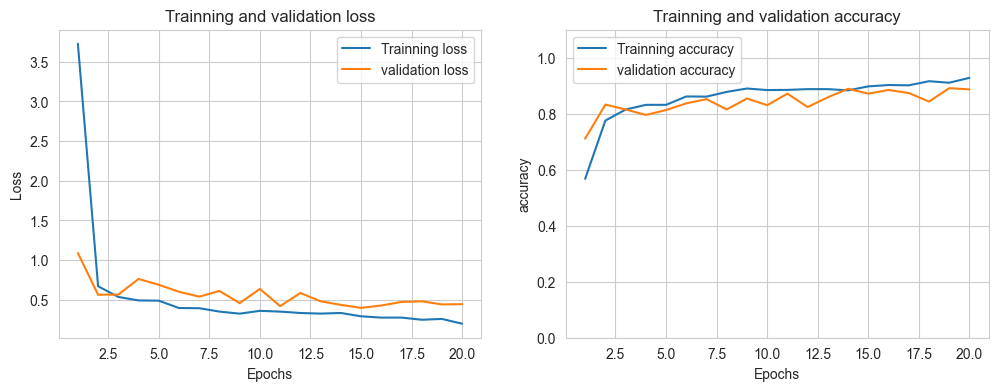

In [21]:
historical_ResNet50v2 = ResNet50v2_custom.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    #validation_data = (images_validation, to_categorical(labels_validation)),
                                    validation_split=.2,
                                    )
plot_history(historical_ResNet50v2)

### Save model and history in disk, delete the from memory to free space to next model

In [22]:
save_model_and_store_history(ResNet50v2_custom, historical_ResNet50v2, 'resnet50v2_custom')
del ResNet50v2_custom, historical_ResNet50v2

C:\Users\edfli\anaconda3\envs\brain_p37\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## InceptionResNETv2

### Train InceptionResNetv2

Epoch 1/20
58/58 [==============================] - 15s 128ms/step - loss: 3.5352 - accuracy: 0.5343 - val_loss: 0.8846 - val_accuracy: 0.6565
Epoch 2/20
58/58 [==============================] - 5s 86ms/step - loss: 0.6918 - accuracy: 0.7495 - val_loss: 0.4834 - val_accuracy: 0.8043
Epoch 3/20
58/58 [==============================] - 5s 83ms/step - loss: 0.6260 - accuracy: 0.7636 - val_loss: 0.4428 - val_accuracy: 0.8152
Epoch 4/20
58/58 [==============================] - 5s 83ms/step - loss: 0.5255 - accuracy: 0.7919 - val_loss: 1.2761 - val_accuracy: 0.6652
Epoch 5/20
58/58 [==============================] - 5s 83ms/step - loss: 0.5273 - accuracy: 0.8061 - val_loss: 0.4918 - val_accuracy: 0.8196
Epoch 6/20
58/58 [==============================] - 5s 84ms/step - loss: 0.5302 - accuracy: 0.8066 - val_loss: 0.3668 - val_accuracy: 0.8543
Epoch 7/20
58/58 [==============================] - 5s 84ms/step - loss: 0.4281 - accuracy: 0.8377 - val_loss: 0.5035 - val_accuracy: 0.8087
Epoch 8/20


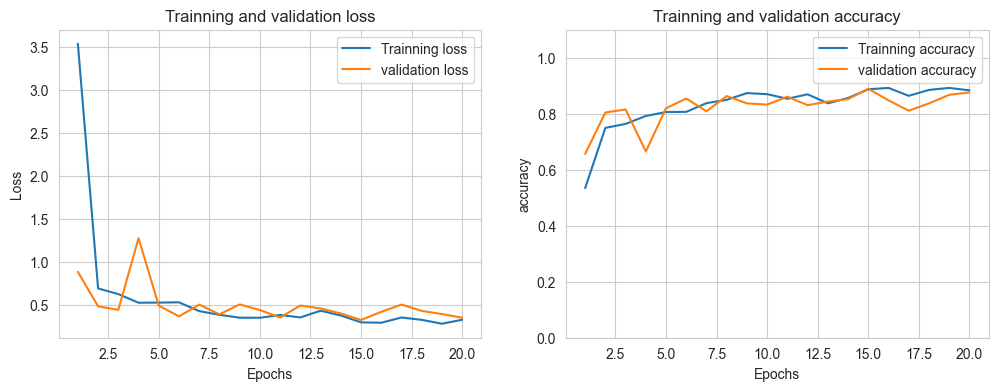

In [23]:
historical_InceptionResNetv2 = InceptionResNetv2_custom.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    #validation_data = (images_validation, to_categorical(labels_validation)),
                                    validation_split=.2,
                                    )
plot_history(historical_InceptionResNetv2)

### Save model and history in disk, delete the from memory to free space to next model

In [24]:
save_model_and_store_history(InceptionResNetv2_custom, historical_InceptionResNetv2, 'InceptionResNetv2_custom')
del InceptionResNetv2_custom, historical_InceptionResNetv2

## MobileNetV2

### Train MobileNetV2

Epoch 1/20
58/58 [==============================] - 5s 37ms/step - loss: 1.8349 - accuracy: 0.6133 - val_loss: 1.3575 - val_accuracy: 0.6609
Epoch 2/20
58/58 [==============================] - 1s 25ms/step - loss: 0.6616 - accuracy: 0.7761 - val_loss: 0.7148 - val_accuracy: 0.8000
Epoch 3/20
58/58 [==============================] - 1s 25ms/step - loss: 0.4587 - accuracy: 0.8344 - val_loss: 0.8694 - val_accuracy: 0.8000
Epoch 4/20
58/58 [==============================] - 1s 25ms/step - loss: 0.4446 - accuracy: 0.8491 - val_loss: 1.3866 - val_accuracy: 0.7152
Epoch 5/20
58/58 [==============================] - 1s 25ms/step - loss: 0.3954 - accuracy: 0.8633 - val_loss: 0.7317 - val_accuracy: 0.8065
Epoch 6/20
58/58 [==============================] - 1s 26ms/step - loss: 0.3767 - accuracy: 0.8568 - val_loss: 1.4339 - val_accuracy: 0.7217
Epoch 7/20
58/58 [==============================] - 2s 26ms/step - loss: 0.3882 - accuracy: 0.8606 - val_loss: 0.8274 - val_accuracy: 0.8217
Epoch 8/20
58

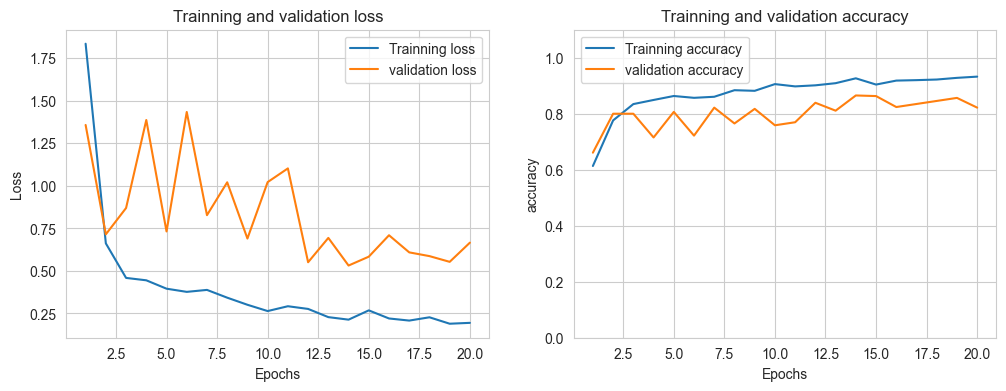

In [25]:
historical_MobileNetv2 = MobileNetv2_custom.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    #validation_data = (images_validation, to_categorical(labels_validation)),
                                    validation_split=.2,
                                    )
plot_history(historical_MobileNetv2)

### Save model and history in disk, delete the from memory to free space to next model

In [26]:
save_model_and_store_history(MobileNetv2_custom, historical_MobileNetv2, 'MobileNetv2_custom')
del MobileNetv2_custom, historical_MobileNetv2

## Simple CNN model

### Train simple CNN model

Epoch 1/20
58/58 [==============================] - 14s 175ms/step - loss: 19.4562 - accuracy: 0.4276 - val_loss: 1.0399 - val_accuracy: 0.5870
Epoch 2/20
58/58 [==============================] - 8s 146ms/step - loss: 0.9119 - accuracy: 0.6400 - val_loss: 0.7509 - val_accuracy: 0.6804
Epoch 3/20
58/58 [==============================] - 8s 147ms/step - loss: 0.7435 - accuracy: 0.7206 - val_loss: 0.7034 - val_accuracy: 0.7043
Epoch 4/20
58/58 [==============================] - 8s 144ms/step - loss: 0.6456 - accuracy: 0.7609 - val_loss: 0.7205 - val_accuracy: 0.7283
Epoch 5/20
58/58 [==============================] - 8s 144ms/step - loss: 0.5031 - accuracy: 0.8121 - val_loss: 0.6589 - val_accuracy: 0.7674
Epoch 6/20
58/58 [==============================] - 8s 144ms/step - loss: 0.4144 - accuracy: 0.8426 - val_loss: 0.6129 - val_accuracy: 0.8043
Epoch 7/20
58/58 [==============================] - 8s 145ms/step - loss: 0.3276 - accuracy: 0.8796 - val_loss: 0.6178 - val_accuracy: 0.7891
Epoc

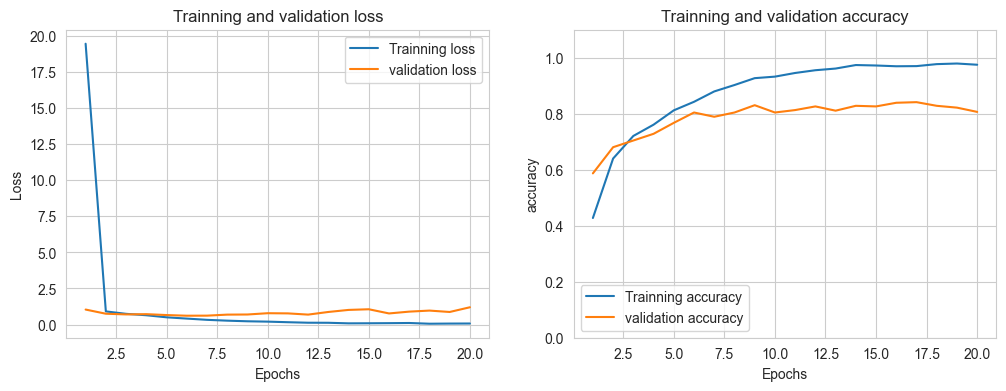

In [27]:
historical_simple_CNN = simple_CNN.fit(x = images_training,
            y = to_categorical(labels_training),
            batch_size=32,
            epochs=20,
            #validation_data = (images_validation, to_categorical(labels_validation)),
            validation_split=.2,
            #callbacks=[tensorboard,es],
            )
plot_history(historical_simple_CNN)

### Save model and history in disk, delete the from memory to free space to next model

In [28]:
save_model_and_store_history(simple_CNN, historical_simple_CNN, 'simple_CNN')
del simple_CNN, historical_simple_CNN